In [1]:
#if alreasy installed, don't need to run following codes
#!conda update conda
#!conda config --add channels conda-forge
#!conda install spacy -y
#!python -m spacy download en

#!conda install scikit-learn -y
#!conda install beautifulsoup4 -y
#!conda install elasticsearch -y
#!pip install pyLDAvis

#for error ModuleNotFoundError: No module named 'cycler' when import matplotlib
#remember restart this notebook or using importlib.reload
#!conda remove matplotlib -y
#!conda remove cycler -y
#!pip uninstall cycler -y
#!pip uninstall matplotlib -y
#!pip install cycler
#!pip install matplotlib
!pip install memory_profiler

In [8]:
from sklearn.model_selection import train_test_split
import time
import multiprocessing
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,9]
  
from Models import DataLoadModel
from Utils import utilTools,utilDataPreprocess,utilLDA
import importlib
importlib.reload(DataLoadModel)
importlib.reload(utilTools)
importlib.reload(utilLDA)
importlib.reload(utilDataPreprocess)

IDFILE="./idlist_cleaned.pkl"
DATAFILE_CLEANED="./preprocessed_data_cleaned.pkl"
DATAFILE_TOKENIZED="./preprocessed_data_tokenized.pkl"
DATAFILE_VECTORIZED="./preprocessed_data_vectorized.pkl"
VECTORIZERFILE = "./vectorizer.pkl"

In [9]:
def saveCleanedData(idlist, data):
    if idlist is None or data is None:
         raise ValueError('you must input two valid objects')
    try:
        utilTools.pickleDump(IDFILE, idlist)
        utilTools.pickleDump(DATAFILE_CLEANED, data)
    except Exception as e:
        print(e)
        print("save failed, idfile={}, dataFile={}".format(IDFILE, DATAFILE_CLEANED))
        raise e
        
# EOFError: Ran out of input, if file size is 0
def loadCleanedData():
    try:
        idlist = utilTools.pickleLoad(IDFILE)
        data = utilTools.pickleLoad(DATAFILE_CLEANED)
    except Exception as e:
        print(e)
        print("load failed, idfile={}, dataFile={}".format(IDFILE, DATAFILE_CLEANED))
        raise e
        
    return idlist, data  

In [10]:
def saveVectorizedData(data, vectorizer):
    if idlist is None or data is None or vectorizer is None:
         raise ValueError('you must input two valid objects')
    try:
        utilTools.pickleDump(DATAFILE_VECTORIZED, data)
        utilTools.dillDump(VECTORIZERFILE, vectorizer)
    except Exception as e:
        print(e)
        print("save failed,dataFile={}, vectorizerFile={}".format(DATAFILE_VECTORIZED, VECTORIZERFILE))
        raise e
        
def loadVectorizedData():
    try:
        data = utilTools.pickleLoad(DATAFILE_VECTORIZED)
        vectorizer = utilTools.dillLoad(VECTORIZERFILE)
    except Exception as e:
        print(e)
        print("load failed, dataFile={}, vectorizerFile={}".format(DATAFILE_VECTORIZED, VECTORIZERFILE))
        raise e
        
    return data, vectorizer

In [11]:
def loadAndCleanData(force_reload=False, n_jobs=1, force_reload_file=None, force_reload_count=-1):
    try:
        if force_reload:
            raise ValueError("will force reload data...")
        start_time = time.time()
        idlist, data = loadCleanedData()
        end_time = time.time()
        print("load {} preprocessed cleaned records in {} Seconds".format(len(idlist), end_time - start_time))
    except Exception as e:
        print("load preprocessed data failed, Will retrieve from dataset...")
        start_time = time.time()
        data = DataLoadModel.loadStackoverflowFromXML(force_reload_file, force_reload_count)
        #data = DataLoadModel.iterLoadStackoverflowFromES(1000)
        end_time = time.time()
        print("Retrieved {} records in {} Seconds".format(len(data), end_time - start_time))
        
        start_time = time.time()
        X_train = [row[1] for row in data]
        idlist = [row[0] for row in data]
        cleaner = utilDataPreprocess.CleanTextTransformer(n_jobs=n_jobs)
        data = cleaner.fit_transform(X_train)
        try:
            saveCleanedData(idlist, data)
            pass
        except Exception as e:
            print(e)
            print("pickleDump cleaned data Failed")
        end_time = time.time()
        print("clean data in {} Seconds".format(end_time - start_time))
        
    return idlist, data

In [12]:
#https://stackoverflow.com/questions/11025005/python-sharing-a-dictionary-between-parallel-processes
#https://stackoverflow.com/questions/5442910/python-multiprocessing-pool-map-for-multiple-arguments
def tokenizeAndVectorieData(data_in, force_reprocess=False, n_jobs=1, min_df=1, max_df = 1.0, max_features=20000):
    #tokenized
    try:
        if force_reprocess:
            raise ValueError("will force reprocess, tokenizing data...")
        start_time = time.time()
        tokenized_data= utilTools.pickleLoad(DATAFILE_TOKENIZED)
        end_time = time.time()
        print("load preprocessed tokenized data in {} Seconds".format(end_time - start_time))
    except Exception as e:
        print("load preprocessed tokenized data failed, Will reprocess...")
        start_time = time.time()
        pool = multiprocessing.Pool(n_jobs)
        tokenized_data = pool.map(utilDataPreprocess.tokenizeText, data_in)
        pool.close()
        pool.join()
        try:
            utilTools.pickleDump(DATAFILE_TOKENIZED, tokenized_data)
        except Exception as e:
            print(e)
            print("pickleDump tokenized data Failed")
        end_time = time.time()
        print("tokenized data in {} Seconds".format(end_time - start_time))
        
    #vectorize, everytime should revectorize for the tokenized data
    vectorized_data, vectorizer = utilDataPreprocess.countvectorizeDataWithTokens(tokenized_data, 
                                                                                  min_df=min_df, 
                                                                                  max_df=max_df,
                                                                                  max_features=max_features)
    try:
        saveVectorizedData(vectorized_data, vectorizer)
    except Exception as e:
        print("pickleDump vectorized data Failed")
        
    return tokenized_data, vectorized_data, vectorizer

In [13]:
def vectorizData(data_in, force_reprocess=False, n_jobs=1, min_df=1, max_df = 1.0, max_features=20000):
    tokens=None
    try:
        if force_reprocess:
            raise ValueError("will force reprocess data...")
        start_time = time.time()
        data, vectorizer = loadVectorizedData()
        end_time = time.time()
        print("load preprocessed vectorized data in {} Seconds".format(end_time - start_time))
    except Exception as e:
        print(e)
        print("load preprocessed vectorized data failed, Will reprocess...")
        tokens, data, vectorizer= tokenizeAndVectorieData(data_in, njobs=n_jobs, min_df=min_df, max_df=max_df, max_features=max_features)
        
    return tokens, data, vectorizer

Wall time: 1 ms
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 332.50 MiB, increment: 0.00 MiB
load preprocessed data failed, Will retrieve from dataset...
Parse XML [F:\stackoverflow.com-Posts\Posts.xml]Done, total [10001] records!
Retrieved 10001 records in 1.2673702239990234 Seconds
clean data in 4.682241678237915 Seconds
load 10001 preprocessed cleaned records in 0.012032032012939453 Seconds


load preprocessed tokenized data failed, Will reprocess...
tokenized data in 42.09628343582153 Seconds
vectorize done in 0.18949103355407715 Seconds


Topic #0:
class object string method new public service type function way result exception property button static input example true thread void
Topic #1:
code application java language event php solution time question people interface framework good specific edit problem different stack lot log
Topic #2:
list text xml html item python tag javascript element character template coll

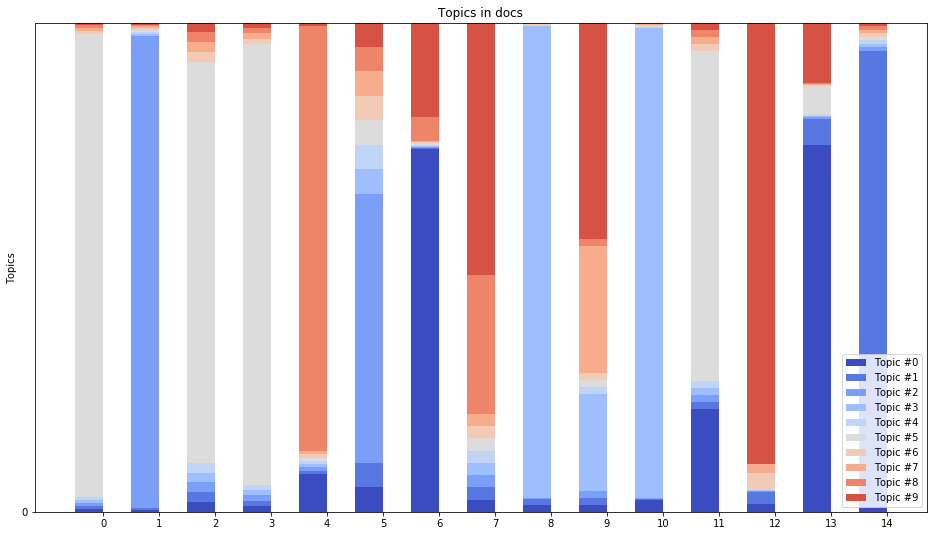

(15, 10)
4
[0.00588612 0.00588293 0.00588318 0.00588513 0.00588235 0.94705025
 0.00588235 0.00588235 0.00588249 0.00588285]

Note: if you're in the IPython notebook, pyLDAvis.show() is not the best command
      to use. Consider using pyLDAvis.display(), or pyLDAvis.enable_notebook().
      See more information at http://pyLDAvis.github.io/quickstart.html .

You must interrupt the kernel to end this command

Serving to http://127.0.0.1:8889/    [Ctrl-C to exit]


127.0.0.1 - - [21/Mar/2018 16:53:42] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Mar/2018 16:53:42] "GET /LDAvis.css HTTP/1.1" 200 -
127.0.0.1 - - [21/Mar/2018 16:53:42] "GET /d3.js HTTP/1.1" 200 -
127.0.0.1 - - [21/Mar/2018 16:53:42] "GET /LDAvis.js HTTP/1.1" 200 -


In [ ]:
%time
%load_ext memory_profiler
#%mprun
%memit

if __name__ == "__main__":
    #Parse XML [F:\stackoverflow.com-Posts\Posts.xml]Done, total [1001] records!
    #Retrieved 1001 records in 0.1178131103515625 Seconds
    #clean data in 2.963881731033325 Seconds
    idlist, cleaned_data = loadAndCleanData(force_reload=True, n_jobs=4, 
                                            force_reload_file=r"F:\stackoverflow.com-Posts\Posts.xml",
                                            force_reload_count=10000)
    idlist, cleaned_data = loadAndCleanData() 
    #cleaned_data_dict=dict(zip(idlist, cleaned_data))
    print("\n")
    
    #tokenized data in 13.708552837371826 Seconds
    #vectorize done in 0.02807474136352539 Seconds
    tokenized_data, vecterized_data, vectorizer = tokenizeAndVectorieData(cleaned_data,
                                                                          force_reprocess = True,
                                                                          n_jobs=4,
                                                                          min_df=5, #5
                                                                          max_df=0.6, #0.6
                                                                          max_features=20000)
    #tokenized_data, vecterized_data, vectorizer = vectorizData(cleaned_data, n_jobs=4,min_df=1,max_df=1.0,max_features=20000)
    #if tokenized_data:
    #    tokenized_data_dict=dict(zip(idlist, tokenized_data))
    #vecterized_data_dict=dict(zip(idlist, vecterized_data))
    print("\n")
    
    start_time = time.time()
    lda = utilLDA.trainLDA(vecterized_data, n_topics=10)
    try:
        utilTools.dillDump("./lda.pkl", lda)
    except:
        pass        
    feature_names = vectorizer.get_feature_names()
    utilLDA.print_top_words(lda, feature_names, 20)
    end_time = time.time()
    print("Trained LDA in {} Seconds".format(end_time - start_time))
    
    #get document_topic_distribution
    doc_topic_distr = lda.transform(vecterized_data[:15])
    utilLDA.visDocTopicDist(doc_topic_distr)
    print(doc_topic_distr.shape)
    print(idlist[0])
    print(doc_topic_distr[0])
    
    #utilLDA.visLDA(lda, vecterized_data, vectorizer, utilTools.getIP(), 8889)
    utilLDA.visLDA(lda, vecterized_data, vectorizer, "127.0.0.1",8889)